### Convolutional neural network that approximates the map
### $$F: \{ \zeta_{i},P^{\mathcal{M}}(\zeta_{i})\}_{i=1}^{N} \mapsto \theta$$
For Heston we have
### $$F: \{ K_{i},T_{j},P^{\mathcal{M}(a,b,c,\rho)}(K_{i},T_{j})\}_{i=1,j=1}^{N,M} \mapsto (a,b,c,\rho)$$
### $$F: \Re^{N} \times \Re^{M} \times \Re^{3} \rightarrow \Re^{4} $$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
from sklearn.preprocessing import MinMaxScaler
import scipy
from IPython.display import clear_output

SyntaxError: invalid syntax (<ipython-input-2-bfa0396e678c>, line 10)

### Define some Variables

In [30]:
num_model_parameters = 4
num_strikes = 6
num_maturities = 4


num_input_parameters = num_strikes * num_maturities * 3
num_output_parameters = num_model_parameters
learning_rate = 0.001
num_steps = 20
batch_size = 6
#num_neurons = 30

#initial values
S0 = 1.0
V0 = 0.2
r = 0.15


contract_bounds = np.array([[0.7*S0,1.3*S0],[1,10]]) #bounds for K,T
model_bounds = np.array([[1,3],[0.1,0.6],[0,0.1],[0,1]]) #bounds for a,b,c,rho, make sure 2ab>c^2


"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

In [31]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def heston(a,b,c,T,W,Z,V0,S0):
    #assert(2*a*b > c*c) 
    
    def mu2(V,i,k):
        return np.multiply(a,(b-V))
    
    def sigma2(V,i,k):
        return np.multiply(c,np.sqrt(np.maximum(0.0,V)))
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(np.sqrt(np.maximum(0.0,V[i,k])),S)
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(X_scaled.shape[-1]-1):
        X[:,:,:,i] = X_scaled[:,:,:,i]*(contract_bounds[i][1]-contract_bounds[i][0]) + contract_bounds[i][0]
    return X

def reverse_transform_y(y_scaled):
    y = np.zeros_like(y_scaled)

    for i in range(y_scaled.shape[-1]):
        y[:,i] = y_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    return y

def next_batch_heston_EM_train(batch_size,contract_bounds,model_bounds,only_prices=False):
    X = np.zeros((batch_size,num_maturities,num_strikes,3))
    X_scaled = np.zeros((batch_size,num_maturities,num_strikes,3))
    y = np.zeros(num_model_parameters)
    y_scaled = np.zeros(num_model_parameters)

    X_scaled[:,:,0,0] = 0.5*uniform.rvs(size=(batch_size,1)) * np.ones((1,num_maturities))
    X_scaled[:,0,:,1] = 0.5*uniform.rvs(size=(batch_size,1)) * np.ones((1,num_strikes))
    
    for i in range(num_strikes):
        if i == 0:
            pass
        X_scaled[:,:,i,0] = X_scaled[:,:,0,0] + i*strikes_distance/(contract_bounds[0][1]-contract_bounds[0][0])
    for i in range(num_maturities):
        if i == 0:
            pass
        X_scaled[:,i,:,1] = X_scaled[:,0,:,1] + i*maturities_distance/(contract_bounds[1][1]-contract_bounds[1][0])

    y_scaled = uniform.rvs(size=(batch_size,4))
     
    X = reverse_transform_X(X_scaled)
    y = reverse_transform_y(y_scaled)
    
    
    n = 200
    dim = 20
    for batch in range(batch_size):  
        for i in range(num_maturities):
            W,Z = corr_brownian_motion(n,X[batch,i,0,1],dim,y[batch,3])
            S,V = heston(y[batch,0],y[batch,1],y[batch,2],X[batch,i,0,0],W,Z,V0,S0)
            S_T = S[:,n]
            
            for j in range(num_strikes):
                X[batch,i,j,2] = np.exp(-r*X[batch,i,0,1])*np.mean(np.maximum(S_T-X[batch,0,j,0],np.zeros(dim)))
                X_scaled[batch,i,j,2] = X[batch,i,j,2]
    if only_prices:
        return X_scaled[:,:,:,2:],y_scaled

    return X_scaled,y_scaled

In [32]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

"""
Create a 2D convolution using builtin conv2d from TF. From those docs:
Computes a 2-D convolution given 4-D input and filter tensors.
Given an input tensor of shape [batch_size, len(T), len(K), #params] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:
Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels].
Extracts image patches from the input tensor to form a virtual tensor of shape [batch_size, len(T), len()K, filter_height * filter_width * #params].
For each patch, right-multiplies the filter matrix and the image patch vector.
"""
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

"""
Args:
  value: A 4-D `Tensor` with shape `[batch_size, len(T), len(K), #params]` and
    type `tf.float32`.
  ksize: A list of ints that has length >= 4.  The size of the window for
    each dimension of the input tensor.
  strides: A list of ints that has length >= 4.  The stride of the sliding
    window for each dimension of the input tensor.
  padding: A string, either `'VALID'` or `'SAME'`. 
"""
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def avg_pool_2by2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [33]:
X = tf.placeholder(tf.float32,shape=[None,num_maturities,num_strikes,1])
y = tf.placeholder(tf.float32, shape=[None,4])

In [34]:
filter_size = 4

"""
nxn Filter
3 `ìmages` as input
32 outputs
"""
convo_1 = convolutional_layer(X,shape=[filter_size,filter_size,1,32]) 
convo_1_pooling = avg_pool_2by2(convo_1)

"""
nxn Filter
32 inputs
32 outputs
"""
convo_2 = convolutional_layer(convo_1_pooling,shape=[filter_size,filter_size,32,16])
convo_2_pooling = avg_pool_2by2(convo_2)


convo_2_flat = tf.reshape(convo_2_pooling,[-1,16*int(np.power(np.maximum(num_maturities,num_strikes),2)/filter_size/filter_size)])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

outputs = fully_connected(full_layer_one, 4, activation_fn=None)

In [35]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

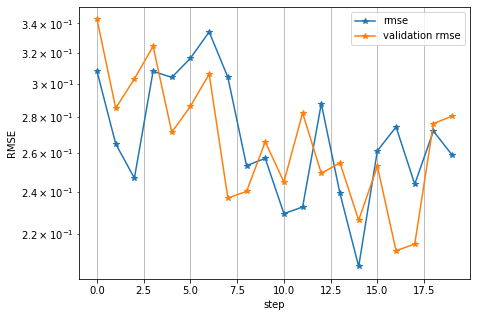

In [36]:
with tf.Session() as sess:
    sess.run(init)
    step = []
    rmse = []
    rmse_val = []
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_heston_EM_train(batch_size,contract_bounds,model_bounds,only_prices=True)
        
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        
        #uncomment for performance
        #"""
        step.append(iteration)
        rmse.append(loss.eval(feed_dict={X: X_batch, y: Y_batch}))
        X_batch_val,Y_batch_val = next_batch_heston_EM_train(batch_size,contract_bounds,model_bounds,only_prices=True)
        rmse_val.append(loss.eval(feed_dict={X: X_batch_val, y: Y_batch_val}))
        
        plt.figure(figsize=(7,5))
        plt.yscale("log")
        plt.xlabel("step")
        plt.ylabel("RMSE")
        plt.grid()
        plt.plot(step,rmse,"*-",label="rmse")
        plt.plot(step,rmse_val,"*-",label="validation rmse")
        clear_output(wait=True)
        plt.legend()
        plt.show()
        #"""
    saver.save(sess, "./models/heston_cnn2")
    

### Next Batch Function